In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib
from matplotlib import pyplot

from keras.models import Sequential
from keras.datasets.cifar10 import load_data
from keras.layers import Conv2D,Conv2DTranspose,Dense,ReLU,LeakyReLU,Flatten,Reshape,Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
(x_train,y_train), (x_test,y_test) = load_data()


170500096/170498071 [==============================] - 11s 0us/step


In [3]:
print(x_train)

[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80  62]
   [ 71  73  61]]

  [[140 155 164]
   [139 146 149]
   [115 115 112]
   ...
   [ 79  82  64]
   [ 68  70  55]
   [ 67  69

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [0]:

def discriminator():
	model = Sequential()
	model.add(Conv2D(64,(3,3),padding='same',input_shape = (32,32,3)))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))
	
	model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))
	model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))

	
	model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))

	model.add(Dense(1,activation = 'sigmoid'))
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)

	model.compile(optimizer= optimus , loss = 'binary_crossentropy' , metrics= ['accuracy'])
	return model

In [0]:
def generator(laten_dim ):
	model = Sequential()
	model.add(Dense(4*4*256 ,input_dim = laten_dim))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Reshape((4,4,256)))
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	
	model.add(Conv2D(3,(3,3),activation='tanh',padding = 'same'))

	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)

	model.compile(optimizer= optimus , loss = 'binary_crossentropy' )
	return model


In [0]:

def gan(g_model,d_model):
    
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)
	model.compile(optimizer = optimus,loss= 'binary_crossentropy'  )
	return model

In [0]:

def load_real_samples():

	(x_train,_),(_,_) = load_data()
	x_train  = x_train.astype('float32')

	x_train = (x_train-127.5)/127.5
	return x_train

In [0]:

def generate_real_samples(dataset , n_samples):

	for i in range (n_samples):
		index = np.random.randint(0 , dataset.shape[0] , n_samples)

		image = dataset[index]
		y = np.ones((n_samples,1))

		return image,y

In [0]:

def generate_latent_sample(laten_dim,n_samples):
	
	x = np.random.randn(laten_dim*n_samples)
	x = x.reshape(n_samples,laten_dim)

	return x

In [0]:

def generate_fake_samples(g_model, latent_dim,n_samples):
	
	x = generate_latent_sample(latent_dim,n_samples)
	x = g_model.predict(x)
	y = np.zeros((n_samples,1))

	return x,y

In [0]:
def save_plot(examples ,epoch , n = 7):
	examples = (examples+1) / 2.0

	for i in range(n*n):
		pyplot.subplot(n,n,1+i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%0.3d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [0]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples = 150):

	x_real ,y_real = generate_real_samples(dataset,n_samples)
	_,acc_real = d_model.evaluate(x_real,y_real)

	x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
	_,acc_fake = d_model.evaluate(x_fake,y_fake)

	print(('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)))
	save_plot(x_fake,epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)



In [0]:
def train(g_model,d_model,gan_model, dataset ,latent_dim, n_epoch = 300, n_batch = 128):
	batch_per_epoch = int(dataset.shape[0]/n_batch)
	batch = int(n_batch/2)

	for i in range(n_epoch):
		for j in range (batch_per_epoch):

			x_real,y_real = generate_real_samples(dataset,batch)

			d_model_loss1,_ = d_model.train_on_batch(x_real,y_real)

			x_fake ,y_fake = generate_fake_samples(g_model,latent_dim,batch)

			d_model_loss2,_ =d_model.train_on_batch(x_fake,y_fake)

			x_gan = generate_latent_sample(latent_dim, n_batch)
			y_gan = np.ones((n_batch,1))

			g_model_loss = gan_model.train_on_batch(x_gan,y_gan)

			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f'% 
                  (i+1, j+1, batch_per_epoch, d_model_loss1, d_model_loss2, g_model_loss))
		if (i+1) % 10 ==0 :
			summarize_performance(i,g_model,d_model,dataset,latent_dim)


In [17]:

latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model,d_model)

d_model.summary()
g_model.summary()
dataset = load_real_samples()

train(g_model,d_model,gan_model,dataset,latent_dim)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)        

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>192, 383/390, d1=0.515, d2=0.433 g=1.506
>192, 384/390, d1=0.590, d2=0.413 g=1.380
>192, 385/390, d1=0.454, d2=0.459 g=1.367
>192, 386/390, d1=0.459, d2=0.573 g=1.411
>192, 387/390, d1=0.522, d2=0.485 g=1.395
>192, 388/390, d1=0.551, d2=0.485 g=1.380
>192, 389/390, d1=0.560, d2=0.446 g=1.437
>192, 390/390, d1=0.476, d2=0.435 g=1.441
>193, 1/390, d1=0.523, d2=0.453 g=1.381
>193, 2/390, d1=0.431, d2=0.416 g=1.383
>193, 3/390, d1=0.404, d2=0.519 g=1.446
>193, 4/390, d1=0.500, d2=0.454 g=1.623
>193, 5/390, d1=0.468, d2=0.328 g=1.560
>193, 6/390, d1=0.573, d2=0.442 g=1.479
>193, 7/390, d1=0.473, d2=0.699 g=1.456
>193, 8/390, d1=0.471, d2=0.445 g=1.569
>193, 9/390, d1=0.509, d2=0.477 g=1.453
>193, 10/390, d1=0.526, d2=0.422 g=1.411
>193, 11/390, d1=0.529, d2=0.442 g=1.403
>193, 12/390, d1=0.458, d2=0.436 g=1.417
>193, 13/390, d1=0.580, d2=0.454 g=1.503
>193, 14/390, d1=0.600, d2=0.498 g=1.366
>193, 15/390, d1=0.469, d2=0.595 g=1.517
>193, 1

KeyboardInterrupt: ignored

lesson learnt
1. train_on_batch on d_model gives 2 argument


Generated Image


<function matplotlib.pyplot.show>

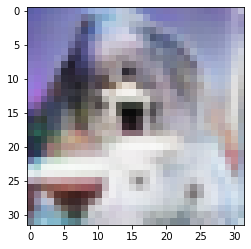

In [76]:
# a sample image

from keras.models import load_model

model = load_model('generator_model_180.h5')
vector = np.asarray([[1.15 for _ in range(100)]])

x= model.predict(vector)
x = (x+1)/2
print("Generated Image")
pyplot.imshow(x[0,:,:])
pyplot.show

Real Image


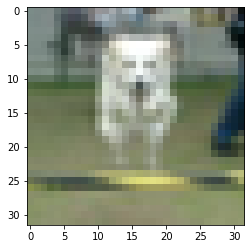

In [61]:
print("Real Image")
pyplot.imshow(x_train[195])